# Analysis of Velocity Distributions to pick a speed threshold for the jump analysis

In [83]:
import cftime
import datetime
import glob
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import pandas as pd
from scipy import signal
from scipy import interpolate 

%matplotlib widget

In [68]:
def window_mean(arr, window_size):
    """
    Compute the window mean (moving average) of an array, keeping the output the same length as the input array and handling NaN values.
    
    Parameters:
    arr (list or np.ndarray): Input array.
    window_size (int): The size of the window to compute the mean.
    
    Returns:
    np.ndarray: Array of window means, padded to the same length as the input array.
    """
    # Convert the input array to a numpy array if it isn't one already
    arr = np.asarray(arr, dtype=float)
    
    # Check if the window size is greater than the array length
    if window_size > len(arr):
        raise ValueError("Window size should be less than or equal to the length of the array.")
    
    # Use pandas rolling function to calculate the window mean, handling NaN values
    result = pd.Series(arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
    
    return result

In [77]:
# Get a list of allthe missions in the data directory
mission_list = glob.glob('../../data/mission_*.nc')

instantaneous_x_vel = []
instantaneous_y_vel = []
progress_counter = 0
for mission_nc in mission_list:    
    # Open the mission file 
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    # Extract the x and y locations of each buoy in the FRF coordinate system
    x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
    y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])

    # Find the number of trajectories in the mission
    number_of_trajectories = x_locations.shape[0]

    # Get the time values of the mission
    time = cftime.num2pydate(mission_dataset['time'],
                                units=mission_dataset['time'].units,
                                calendar=mission_dataset['time'].calendar)
    delta_t = (time[1]-time[0]).total_seconds()

    for trajectory_num in np.arange(number_of_trajectories):
        # Define the filter
        window_size = 36

        # Filter x
        x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
        x_filtered = window_mean(x, window_size)

        # Filter y 
        y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)
        y_filtered = window_mean(y, window_size)

        # Compute the instantaneous velocity from the filtered signal
        instantaneous_x_vel.append(np.gradient(x_filtered, delta_t))
        instantaneous_y_vel.append(np.gradient(y_filtered, delta_t))

    progress_counter += 1

# Flatten the Arrays
instantaneous_x_vel_flat = np.concatenate(instantaneous_x_vel).flatten()
instantaneous_y_vel_flat = np.concatenate(instantaneous_y_vel).flatten()

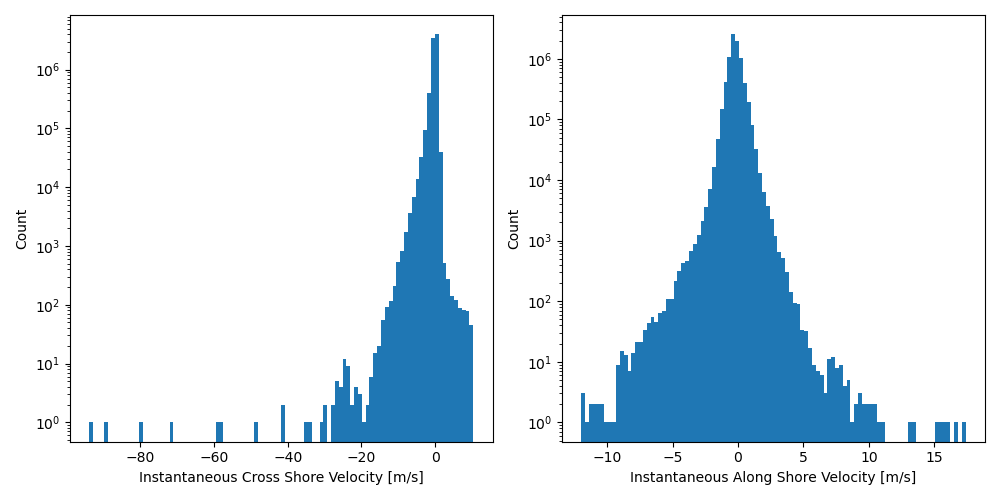

In [82]:
# Plot Histograms of instantaneous velocity
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

nbins = 100

# Cross Shore Velocity
ax1.hist(instantaneous_x_vel_flat, density=False, bins=nbins)
ax1.set_yscale('log')
ax1.set_xlabel('Instantaneous Cross Shore Velocity [m/s]')
ax1.set_ylabel('Count')

# Along Shore Velocity
ax2.hist(instantaneous_y_vel_flat, density=False, bins=nbins)
ax2.set_yscale('log')
ax2.set_xlabel('Instantaneous Along Shore Velocity [m/s]')
ax2.set_ylabel('Count')

plt.tight_layout()

There is a bit of a bimodal distribution in the cross shore velocity distribution - although the value of the velocity seems spuriously large and the number of points there are very few O(10) points which is not representative of what we are looking for. Lets try normalizing each point by the linear phase speed and see if anything comes out

In [87]:

def bathy_along_track(bathy_file:str, xFRF:np.ndarray, yFRF:np.ndarray,
                      single_trajectory=False):
    """
    Linearly interpolates the bathymetry along the track of
    the microSWIFT.

    Parameters
    ----------
    bathy_file : str
        url or path to bathy bathymetry file
    xFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    yFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    single_trajectory : boolean
        True or False if plotting a single trajectory

    Returns
    -------
    bathy_along_track : np.ndarray
        1D or 2D array of bottom elevation at each location along the track

    """
    if single_trajectory is True:
        xFRF = xFRF.reshape(1,xFRF.size)
        yFRF = yFRF.reshape(1,yFRF.size)
    else:
        pass
    
    # Create bathymetry interpolating function from 2D grid
    bathy_dataset = nc.Dataset(bathy_file)
    x = bathy_dataset['xFRF'][:]
    y = bathy_dataset['yFRF'][:]
    z = bathy_dataset['elevation'][0,:,:]
    bathy_f = interpolate.RegularGridInterpolator((x, y), np.transpose(z), 
                                                  method='linear', bounds_error=False)

    bathy_along_track = np.empty(xFRF.shape)
    for trajectory in range(xFRF.shape[0]):
        for n in np.arange(xFRF.shape[1]):
            point = np.array([xFRF[trajectory, n],
                              yFRF[trajectory, n]])
            bathy_along_track[trajectory, n] = np.squeeze(bathy_f(point).item())

    return np.array(bathy_along_track)

# Get a list of allthe missions in the data directory
mission_list = glob.glob('../../data/mission_*.nc')

mission_df = pd.read_csv('../../data/mission_df.csv').sort_values(by=['mission number'])

instantaneous_x_vel_normalized = []
instantaneous_y_vel_normalized = []
progress_counter = 0
for mission_nc in mission_list:    
    # Open the mission file 
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    # Extract the x and y locations of each buoy in the FRF coordinate system
    x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
    y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])

    # Find the number of trajectories in the mission
    number_of_trajectories = x_locations.shape[0]

    # Get the time values of the mission
    time = cftime.num2pydate(mission_dataset['time'],
                                units=mission_dataset['time'].units,
                                calendar=mission_dataset['time'].calendar)
    delta_t = (time[1]-time[0]).total_seconds()

    mission_num = int(mission_nc[19:-3])
    water_level = mission_df[mission_df['mission number'] == mission_num]['water level [m]'].values[0]

    for trajectory_num in np.arange(number_of_trajectories):
        # Define the filter
        window_size = 36

        # Filter x
        x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
        x_filtered = window_mean(x, window_size)

        # Filter y 
        y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)
        y_filtered = window_mean(y, window_size)

        # Compute the instantaneous velocity from the filtered signal
        x_vel = np.gradient(x_filtered, delta_t)
        y_vel = np.gradient(y_filtered, delta_t)

        # Depth Along Trajectory
        trajectory_bathy = bathy_along_track(bathy_file='../../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                            xFRF=x_filtered, 
                                                            yFRF=y_filtered,
                                                            single_trajectory=True)[0]
        trajectory_depth = trajectory_bathy + water_level

        # Compute Linear Phase Speed at each point in track
        phase_speed_along_track = np.sqrt(np.abs(trajectory_depth * 9.8))

        # Compute normalized instantaneous veloctiy
        instantaneous_x_vel_normalized.append(x_vel/phase_speed_along_track)
        instantaneous_y_vel_normalized.append(y_vel/phase_speed_along_track)

    
    progress_counter += 1

# Flatten the Arrays
instantaneous_x_vel_normalized_flat = np.concatenate(instantaneous_x_vel_normalized).flatten()
instantaneous_y_vel_normalized_flat = np.concatenate(instantaneous_y_vel_normalized).flatten()

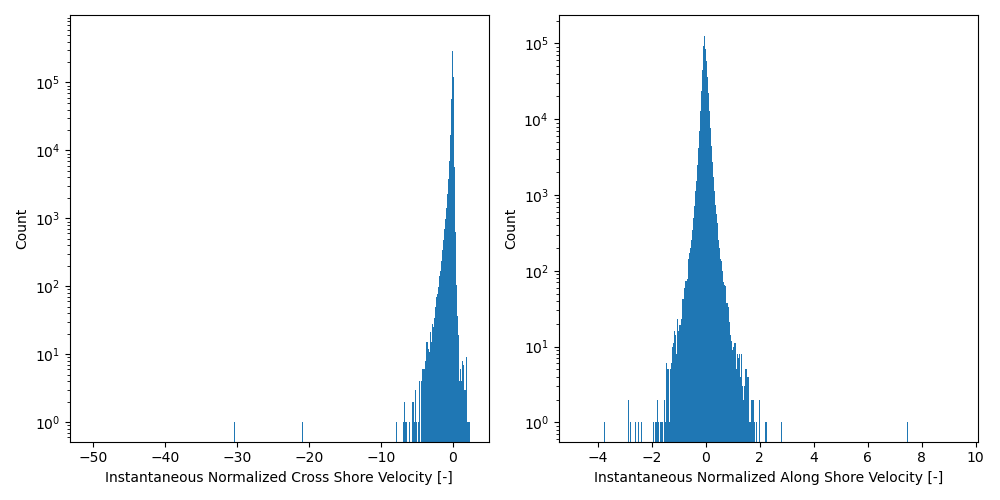

In [91]:
# Plot Histograms of instantaneous velocity
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

nbins = 5000

# Cross Shore Velocity

ax1.hist(instantaneous_x_vel_normalized_flat, density=False, bins=nbins)
ax1.set_yscale('log')
ax1.set_xlabel('Instantaneous Normalized Cross Shore Velocity [-]')
ax1.set_ylabel('Count')

# Along Shore Velocity
ax2.hist(instantaneous_y_vel_normalized_flat, density=False, bins=nbins)
ax2.set_yscale('log')
ax2.set_xlabel('Instantaneous Normalized Along Shore Velocity [-]')
ax2.set_ylabel('Count')

plt.tight_layout()